In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

In [2]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.10.1


In [3]:
experiment_id = "MLAoOqyNQ6mwbWwgWDKj3g"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,PPO_V12.2,rollout/ep_len_mean,1024,1000.000000
1,PPO_V12.2,rollout/ep_len_mean,1536,1000.000000
2,PPO_V12.2,rollout/ep_len_mean,2048,1000.000000
3,PPO_V12.2,rollout/ep_len_mean,2560,1000.000000
4,PPO_V12.2,rollout/ep_len_mean,3072,1000.000000
...,...,...,...,...
286358,PPO_V12.2,train/value_loss,12263424,27.643383
286359,PPO_V12.2,train/value_loss,12263936,0.266144
286360,PPO_V12.2,train/value_loss,12264448,34.730896
286361,PPO_V12.2,train/value_loss,12264960,52.956989


In [4]:
csv_path = 'PPO_Training_Log.csv'
df.to_csv(csv_path, index=False)
df_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(df_roundtrip, df)

In [5]:
print(df["run"].unique())

['PPO_V12.2']


In [6]:
print(df["tag"].unique())

['rollout/ep_len_mean' 'rollout/ep_rew_mean' 'time/fps' 'train/approx_kl'
 'train/clip_fraction' 'train/clip_range' 'train/entropy_loss'
 'train/explained_variance' 'train/learning_rate' 'train/loss'
 'train/policy_gradient_loss' 'train/value_loss']


In [7]:
grouped = df.groupby(df.tag)

df_reward = grouped.get_group("rollout/ep_rew_mean")
df_reward

,run,tag,step,value
23955,PPO_V12.2,rollout/ep_rew_mean,1024,-517.000000
23956,PPO_V12.2,rollout/ep_rew_mean,1536,-517.000000
23957,PPO_V12.2,rollout/ep_rew_mean,2048,-474.505005
23958,PPO_V12.2,rollout/ep_rew_mean,2560,-474.505005
23959,PPO_V12.2,rollout/ep_rew_mean,3072,-461.339996
...,...,...,...,...
47905,PPO_V12.2,rollout/ep_rew_mean,12263424,-395.024200
47906,PPO_V12.2,rollout/ep_rew_mean,12263936,-392.724213
47907,PPO_V12.2,rollout/ep_rew_mean,12264448,-392.724213
47908,PPO_V12.2,rollout/ep_rew_mean,12264960,-399.334198


In [8]:
import numpy as np

def smooth_list(data, N):
    idx = 0
    window = np.zeros(N)
    smoothed = np.zeros(len(data))

    for i in range(len(data)):
        window[idx] = data[i]
        idx += 1

        smoothed[i] = window[0:idx].mean()

        if idx == N:
            window[0:-1] = window[1:]
            idx = N - 1

    return smoothed

/home/xin/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/xin/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


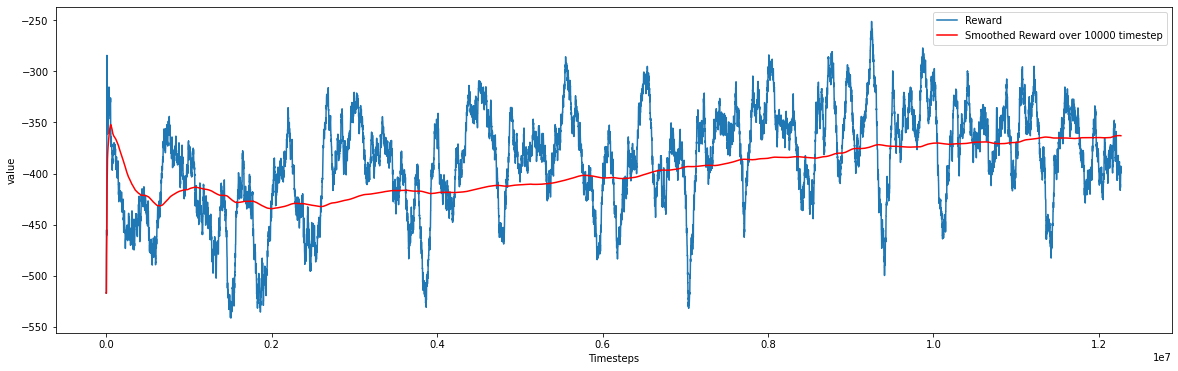

In [21]:
x = df_reward["step"]
y = df_reward["value"]
y2 = smooth_list(df_reward["value"].tolist(), 10000)

fig, ax = plt.subplots(figsize=(20, 6))
ax = sns.lineplot(x, y, label="Returns")
ax.set_xlabel('Timesteps')
ax.set_title("Mean Episode Returns")
ax1 = sns.lineplot(x, y2, color='red', label="Smoothed Returns over 10000 timestep")
